# Performance analysis

In this notebook all the results obtained will be reported, with particular reference to the best configuration for each model.

## Imports

In [1]:
import itertools
import os.path
from typing import List, Dict

import pandas as pd

from src.models.config import param_layers, param_grid_mlp
from src.utils.const import MODEL_RESULTS_CSV, NETWORK_RESULT_CSV
from typing import Tuple
from src.visualization.visualize import barplot_multiple_columns
import numpy as np

### Useful path to data

In [2]:
RESULTS_FOLDER = os.path.join('..', MODEL_RESULTS_CSV)
MLP_RESULTS_FOLDER = os.path.join('..', NETWORK_RESULT_CSV)

## Read output csv

In [3]:
mlp_all = pd.read_csv(os.path.join(MLP_RESULTS_FOLDER, 'out_mlp_all.csv'))
mlp_batch = pd.read_csv(os.path.join(MLP_RESULTS_FOLDER, 'out_bad_config_batch.csv'))

svm_res = pd.read_csv(os.path.join(RESULTS_FOLDER, 'out_svm.csv'))
naive_res = pd.read_csv(os.path.join(RESULTS_FOLDER, 'best_out_naive_bayes.csv'))
tree_res = pd.read_csv(os.path.join(RESULTS_FOLDER, 'best_out_tree_based.csv'))

svm_val = pd.read_csv(os.path.join(RESULTS_FOLDER, 'out_grid_svm.csv'))
naive_val = pd.read_csv(os.path.join(RESULTS_FOLDER, 'out_grid_naive_bayes.csv'))
tree_val = pd.read_csv(os.path.join(RESULTS_FOLDER, 'out_grid_tree_based.csv'))


## Utils

In [4]:
df_test_metric = pd.DataFrame()
df_train_metric=pd.DataFrame()

In [5]:
def mu_confidence_interval(data: np.ndarray) -> Dict:
    """
    Compute mean and t_student from a np.ndarray
    :param data: the DataFrame that contains movies_id and tmdb_id
    :return: Dict with metric values
    """
    t = 2.13
    mu = np.mean(data)
    standard_deviation = np.std(data)
    M = data.shape[0]
    t_student = t * standard_deviation / np.sqrt(M)
    first_interval = mu - t_student
    second_interval = mu + t_student
    return {
        'mu': mu,
        't_student': t_student,
        'first_interval': first_interval,
        'second_interval': second_interval
    }

In [6]:
def get_best_configuration_mlp(cfg: int, p_layer, p_grid_mlp) -> Tuple:
    """
    Compute cartesian product using mlp hyperparams and return
    the configuration specified by the index cfg
    :param cfg: the configuration index to retrieve
    :param p_layer: the network architecture parameters
    :param p_grid_mlp: the network hyperparams
    :return: Tuple with best configuration
    """
    hyper_parameters_model_all = itertools.product(
        p_layer['input_act'],
        p_layer['hidden_act'],
        p_layer['hidden_size'],
        p_layer['num_hidden_layers'],
        p_layer['dropout'],
        p_layer['batch_norm'],
        p_layer['output_fn'],
        p_grid_mlp['num_epochs'],
        p_grid_mlp['starting_lr'],
        p_grid_mlp['batch_size'],
        p_grid_mlp['optim'],
        p_grid_mlp['momentum'],
        p_grid_mlp['weight_decay'],
    )
    return list(hyper_parameters_model_all)[cfg]

In [7]:
def summary_statistics_model(df_score: pd.DataFrame, dict_: Dict, model: str, train: bool = False) -> pd.DataFrame:
    if not train:
        print(
            f"Best configuration {model} mean metrics:\n"
            f"f1_score: {dict_['f1']['mu']} ±{dict_['f1']['t_student']}\n"
            f"loss: {dict_['loss']['mu']} ±{dict_['loss']['t_student']}\n"
            f"acc: {dict_['acc']['mu']} ±{dict_['acc']['t_student']}\n\n"
            f"Best hyperparams configuration:"
        )
        if model == "mlp" or model=='MLP':
            best_cfg_mlp_all = get_best_configuration_mlp(int(dict_['conf']), param_layers, param_grid_mlp)
            for idx, key in enumerate(param_layers.keys()):
                print(f"{key}: {best_cfg_mlp_all[idx]}")
            for idx, key in enumerate(param_grid_mlp.keys(), 7):
                print(f"{key}: {best_cfg_mlp_all[idx]}")
        else:
            print(f"{dict_['conf']}")

        new_test_score = pd.DataFrame({
            'model': [model],
            'f1_mu': [dict_['f1']['mu']],
            'acc_mu': [dict_['acc']['mu']],
            'loss_mu': [dict_['loss']['mu']],
            'f1_ci': [dict_['f1']['t_student']],
            'acc_ci': [dict_['acc']['t_student']],
            'loss_ci': [dict_['loss']['t_student']],
        })
        df_score = pd.concat([df_score, new_test_score], ignore_index=True)
    else:
        print(
            f"Best configuration {model} mean metrics:\n"
            f"train f1: {dict_['train_score']['mu']} ±{dict_['train_score']['t_student']}\n"
            f"validation f1: {dict_['val_score']['mu']} ±{dict_['val_score']['t_student']}\n"
        )
        new_test_score = pd.DataFrame({
            'model': [model],
            'train_score': [dict_['train_score']['mu']],
            'val_score': [dict_['val_score']['mu']],
            'train_ci': [dict_['train_score']['t_student']],
            'val_ci': [dict_['val_score']['t_student']]
        })
        df_score = pd.concat([df_score, new_test_score], ignore_index=True)
    return df_score

In [8]:
def find_max_f1_cfg(df: pd.DataFrame) -> List:
    """
    Find best configuration based on f1-score
    :param data: the DataFrame that contains model outputs
    :return: List with best configuration indeces
    """
    cfg = []
    for fold in df['fold'].unique():
        idx = df[df['fold'] == fold]['f1_test'].idxmax()
        cfg.append(df.iloc[idx]['cfg'])
    cfgs = np.unique(np.array(cfg))
    return cfgs

In [9]:
def find_best_conf(lst_conf, df: pd.DataFrame) -> Dict:
    conf = []
    for idx, cfg in enumerate(lst_conf):
        conf.append(
            {
                'f1': mu_confidence_interval(df[df['cfg'] == cfg]['f1_test']),
                'loss': mu_confidence_interval(df[df['cfg'] == cfg]['loss_test']),
                'acc': mu_confidence_interval(df[df['cfg'] == cfg]['acc_test'])
            }
        )
        conf[idx]['conf'] = cfg
        conf[idx]['acc']['mu'] /= 100
        conf[idx]['acc']['t_student'] /= 100
    max = conf[0]
    for elm in conf:
        if max['f1']['mu'] < elm['f1']['mu'] and max['f1']['t_student'] > elm['f1']['t_student']:
            max = elm
    return max

In [10]:
def calculate_statistics_sklearn(df: pd.DataFrame, model: str) -> Dict:
    """
    Create a well-formatted Dict that contains the metrics
    :param df: the DataFrame that contains metrics
    :return: well-formatted Dict
    """
    res = {'f1': mu_confidence_interval(df[df['model'] == model]['f1_test']),
           'loss': mu_confidence_interval(df[df['model'] == model]['loss_test']),
           'acc': mu_confidence_interval(df[df['model'] == model]['acc_test']),
           'conf': df[df['model'] == model]['cfg'].unique()}
    return res

In [11]:
def calculate_statistics_sklearn_train(df: pd.DataFrame, first:bool=True) -> Dict:
    if first:
        res = {'train_score': mu_confidence_interval(df['mean_train_score'].iloc[0:5]),
               'val_score': mu_confidence_interval(df['mean_test_score'].iloc[0:5]),
               }
    else:
        res = {'train_score': mu_confidence_interval(df['mean_train_score'].iloc[5:10]),
               'val_score': mu_confidence_interval(df['mean_test_score'].iloc[5:10]),
               }
    return res

In [12]:
def calculate_statistics_mlp_train(cfg:int, df: pd.DataFrame) -> Dict:
    """
    Create a well-formatted Dict that contains the metrics
    :param cfg: the configuration index
    :param cfg: the DataFrame that contains metric
    :return: well-formatted Dict
    """
    res = {'train_score': mu_confidence_interval(df[df['cfg'] == cfg]['mean_f1_train']),
               'val_score': mu_confidence_interval(df[df['cfg'] == cfg]['mean_f1_val']),
               }
    return res

In [13]:
def add_value_array(old_list: List, df_test: pd.DataFrame, col_name: str, last_idx: int) -> None:
    for model_name in df_test['model'].unique():
        if col_name == 'metrics':
            metric_value = df_test[df_test['model'] == model_name].iloc[:, 1:last_idx].iloc[0]
        else:
            metric_value = df_test[df_test['model'] == model_name].iloc[:, last_idx:].iloc[0]

        old_list.append(np.array(metric_value))

## Work with results

### Scikit-learn models

#### RandomForestClassifier

In [14]:
res_random_forest_train = calculate_statistics_sklearn_train(tree_val)
df_train_metric = summary_statistics_model(df_train_metric, res_random_forest_train, 'Random forest classifier', train=True)

res_random_forest = calculate_statistics_sklearn(tree_res, 'random_forest_classifier')
df_test_metric = summary_statistics_model(df_test_metric, res_random_forest, 'Random forest classifier')

Best configuration Random forest classifier mean metrics:
train f1: 0.7894708757467401 ±0.0028370536720411406
validation f1: 0.7813933618457191 ±0.0025529991410781342

Best configuration Random forest classifier mean metrics:
f1_score: 0.609756989767005 ±0.006529683898881055
loss: 0.39225757744490736 ±0.00712946750658302
acc: 0.6077424225550925 ±0.007129467506583035

Best hyperparams configuration:
["{'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 700}"]


#### DecisionTreeClassifier

In [15]:
res_decision_tree_train = calculate_statistics_sklearn_train(tree_val,first=False)
df_train_metric = summary_statistics_model(df_train_metric, res_decision_tree_train, 'Decision tree classifier', train=True)

res_decision_tree = calculate_statistics_sklearn(tree_res, 'decision_tree_classifier')
df_test_metric = summary_statistics_model(df_test_metric, res_decision_tree, 'Decision tree classifier')

Best configuration Decision tree classifier mean metrics:
train f1: 0.9982448027541722 ±0.0001574523340800961
validation f1: 0.8668832921611014 ±0.0011549731147417086

Best configuration Decision tree classifier mean metrics:
f1_score: 0.6402913493313054 ±0.004216781363865863
loss: 0.36008162828469237 ±0.004052145718922026
acc: 0.6399183717153076 ±0.004052145718922028

Best hyperparams configuration:
["{'criterion': 'entropy', 'max_depth': 15}"]


#### GaussianNB

In [16]:
res_gaussian_nb_train = calculate_statistics_sklearn_train(naive_val)
df_train_metric = summary_statistics_model(df_train_metric, res_gaussian_nb_train, 'GaussianNB', train=True)

res_gaussian_nb = calculate_statistics_sklearn(naive_res, 'gaussian_nb')
df_test_metric = summary_statistics_model(df_test_metric, res_gaussian_nb, 'GaussianNB')

Best configuration GaussianNB mean metrics:
train f1: 0.7216627770722026 ±0.00336266744134676
validation f1: 0.7074634406645496 ±0.003231430093703336

Best configuration GaussianNB mean metrics:
f1_score: 0.4526802764969494 ±0.010686051270129714
loss: 0.5481864029029817 ±0.010409238716856704
acc: 0.4518135970970182 ±0.010409238716856686

Best hyperparams configuration:
["{'var_smoothing': 8.111308307896872e-07}"]


#### QDA

In [17]:
res_qda_train = calculate_statistics_sklearn_train(naive_val,first=False)
df_train_metric = summary_statistics_model(df_train_metric, res_qda_train, 'QDA', train=True)

res_qda = calculate_statistics_sklearn(naive_res, 'qda')
df_test_metric = summary_statistics_model(df_test_metric, res_qda, 'QDA')

Best configuration QDA mean metrics:
train f1: 0.9870351447504125 ±0.00035963628820091814
validation f1: 0.8985859150139989 ±0.0007798478399543219

Best configuration QDA mean metrics:
f1_score: 0.5217235201683785 ±0.007963795942101407
loss: 0.4649740608914607 ±0.00827922547607728
acc: 0.5350259391085392 ±0.00827922547607726

Best hyperparams configuration:
["{'reg_param': 0.001, 'tol': 0.0001}"]


#### SVM

In [18]:
res_svm_train = calculate_statistics_sklearn_train(svm_val)
df_train_metric = summary_statistics_model(df_train_metric, res_svm_train, 'SVM', train=True)

res_svm = calculate_statistics_sklearn(svm_res, 'svc')
df_test_metric = summary_statistics_model(df_test_metric, res_svm, 'SVM')

Best configuration SVM mean metrics:
train f1: 0.9999782608688632 ±1.1833105435719024e-05
validation f1: 0.9613343635021987 ±0.000923195543662202

Best configuration SVM mean metrics:
f1_score: 0.8286206857647119 ±0.004227564469616818
loss: 0.17076133850717423 ±0.004051273714411658
acc: 0.8292386614928257 ±0.004051273714411657

Best hyperparams configuration:
["{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}"]


### MovieNet (MLP)

In [19]:
best_cfg = find_max_f1_cfg(mlp_all)
print(f'Indices of the best configurations: {best_cfg}')

Indices of the best configurations: [ 3. 17. 18. 35.]


In [20]:
res_mlp_train = calculate_statistics_mlp_train(3,mlp_all)
df_train_metric = summary_statistics_model(df_train_metric, res_mlp_train, 'MLP', train=True)

res_mlp = find_best_conf(best_cfg, mlp_all)
df_test_metric = summary_statistics_model(df_test_metric, res_mlp, "MLP")

Best configuration MLP mean metrics:
train f1: 0.8755459737044162 ±0.0019265183510115194
validation f1: 0.7959136321829858 ±0.0008824929662534333

Best configuration MLP mean metrics:
f1_score: 0.8592441948011021 ±0.003684042440349958
loss: 0.36027745032868336 ±0.007651729397571641
acc: 0.8590550846293245 ±0.0036778811434022662

Best hyperparams configuration:
input_act: LeakyReLU(negative_slope=0.01)
hidden_act: LeakyReLU(negative_slope=0.01)
hidden_size: 512
num_hidden_layers: 3
dropout: 0.2
batch_norm: False
output_fn: None
num_epochs: 200
starting_lr: 0.001
batch_size: 128
optim: <class 'torch.optim.adam.Adam'>
momentum: 0.9
weight_decay: 1e-07


### Plot results

#### Train & Validation

In [21]:
metrics = []
y_errs = []
add_value_array(metrics, df_train_metric, 'metrics', 3)
add_value_array(y_errs, df_train_metric, 'interval', 3)

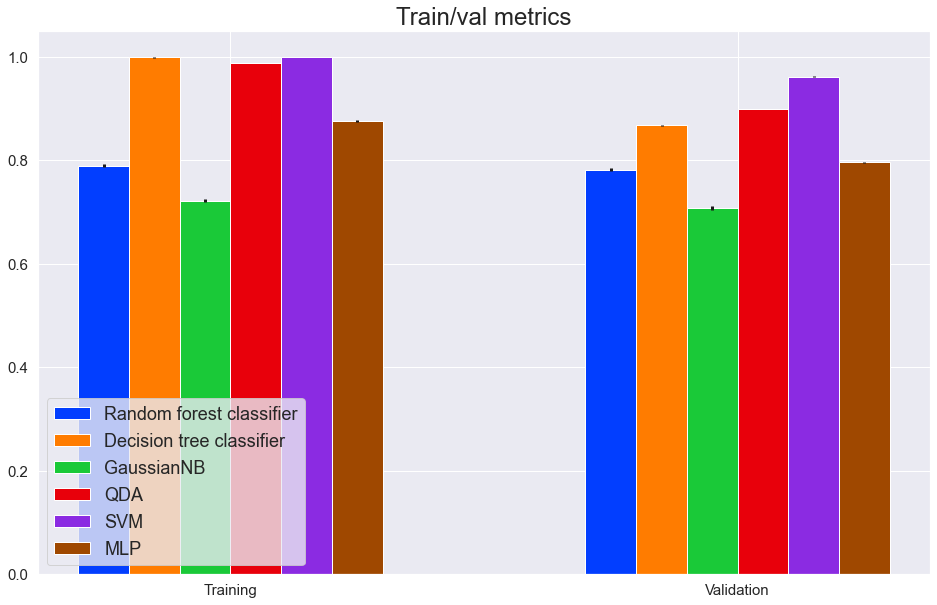

In [22]:
barplot_multiple_columns(groups=['Training', 'Validation'],
                         elements_group=df_train_metric['model'].unique(), data=metrics, yerr=y_errs,
                         title='Train/val metrics',
                         upper_title=False)

#### Test

In [23]:
metrics = []
y_errs = []
add_value_array(metrics, df_test_metric, 'metrics', 4)
add_value_array(y_errs, df_test_metric, 'interval', 4)

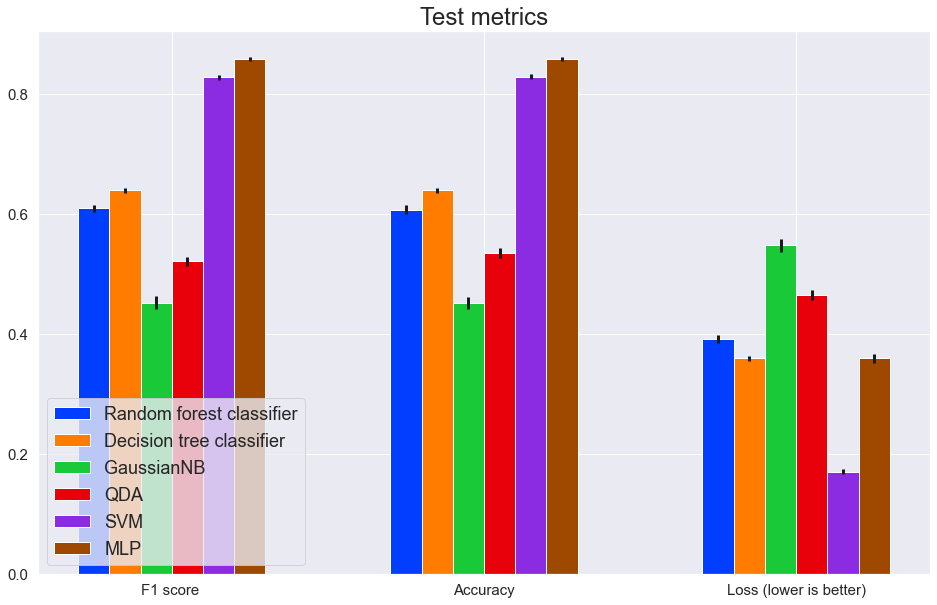

In [24]:
barplot_multiple_columns(groups=['F1 score ', 'Accuracy', 'Loss (lower is better)'],
                         elements_group=df_test_metric['model'].unique(), data=metrics, yerr=y_errs,
                         title='Test metrics',
                         upper_title=False)